<a href="https://colab.research.google.com/github/MariaPerezCatalinas/PRACTICA5/blob/main/Pr%C3%A1ctica_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 5

En esta práctica deberás implementar distintos métodos de aprendizaje semi-supervisado. 

## Ejercicio obligatorio: Pseudo-labeling (5 puntos)

A continuación se listan una serie de datasets que están disponibles en Kaggle (algunos de los datasets seleccionados han sido recortados para que puedan entrenarse los modelos en un tiempo razonable). Para cada uno de ellos se os proporciona un enlace al dataset para que podáis descargarlo directamente. Elige uno de los siguientes datasets (o uno de tu elección) y realiza los ejercicios detallados a continuación. 

- [Blidness dataset](https://www.kaggle.com/c/aptos2019-blindness-detection). Enlace: https://www.dropbox.com/s/cv5dfjagvj8fqk8/blindness.zip?dl=1.
- [Chest xRay dataset](https://www.kaggle.com/nih-chest-xrays/data). Enlace: https://www.dropbox.com/s/q6s4wu7q3yrpwrm/chest_xray.zip?dl=1.
- [Docknet dataset](https://www.kaggle.com/gavinarmstrong/open-sprayer-images). Enlace: https://www.dropbox.com/s/a5pzvpafvgfqvf0/Docknet.zip?dl=1.
- [Tobacco dataset](https://www.kaggle.com/sprytte/tobacco-800-dataset). Enlace: https://www.dropbox.com/s/wy44c0rsv8jogka/tobacco.zip?dl=1. 

Comienza descargando el dataset de tu elección. 

In [1]:
%%capture
!wget https://www.dropbox.com/s/q6s4wu7q3yrpwrm/chest_xray.zip?dl=1 -O chest_xray.zip
!unzip chest_xray.zip

Vamos a simular un entorno semi-supervisado para lo cual tienes que reestructurar tu dataset de manera que en el conjunto de entrenamiento haya únicamente 20 imágenes por clase, y el resto de imágenes las guardarás en una carpeta llamada unlabelled. Al acabar, tu estructura de carpetas debería ser algo similar a lo siguiente:

```.
└── dataset
    ├── test
    │   ├── claseA
    │   └── claseB
    ├── train
    │   ├── claseA
    │   └── claseB
    └── unlabelled
```

In [2]:
import os
import shutil

directorio = "dataset"

os.mkdir(directorio)
os.mkdir('/content/dataset/test')
os.mkdir('/content/dataset/test/NORMAL')
os.mkdir('/content/dataset/test/PNEUMONIA')
os.mkdir('/content/dataset/train')
os.mkdir('/content/dataset/train/NORMAL')
os.mkdir('/content/dataset/train/PNEUMONIA')
os.mkdir('/content/dataset/unlabelled')

In [3]:
# NORMAL TRAIN
origen = "/content/chest_xray/train/NORMAL"

destino = "/content/dataset/train/NORMAL"
sin_etiquetas = "/content/dataset/unlabelled"

# Obtener la lista de archivos en el directorio de origen
lista_archivos = os.listdir(origen)

# Copiar los primeros 20 archivos
for archivo in lista_archivos[:20]:
  
  archivo_origen = os.path.join(origen, archivo)
  archivo_destino = os.path.join(destino)
  shutil.copy(archivo_origen, archivo_destino)

for archivo in lista_archivos[20:]:
  archivo_origen = os.path.join(origen, archivo)
  archivo_destino = os.path.join(sin_etiquetas)
  shutil.copy(archivo_origen, archivo_destino)

In [4]:
# PNEUMONIA TRAIN

origen = "/content/chest_xray/train/PNEUMONIA"

# Directorio de destino
destino = "/content/dataset/train/PNEUMONIA"

# Obtener la lista de archivos en el directorio de origen
lista_archivos = os.listdir(origen)

# Copiar los primeros 20 archivos
for archivo in lista_archivos[:20]:

  archivo_origen = os.path.join(origen, archivo)
  archivo_destino = os.path.join(destino)
  shutil.copy(archivo_origen, archivo_destino)

for archivo in lista_archivos[20:]:
  archivo_origen = os.path.join(origen, archivo)
  archivo_destino = os.path.join(sin_etiquetas)
  shutil.copy(archivo_origen, archivo_destino)

Siguiendo los pasos de la práctica 1 entrena un modelo con el dataset que has creado y evalúalo en el conjunto de test. Añade a continuación todas las celdas que necesites.

### Librerías

Inicialmente se necesitará descargar la última versión de la librería FastAI. No debemos olvidar reiniciar el kernel una vez haya finalizado la instalación (menú Entorno de ejecución -> Reiniciar Entorno de ejecución).

In [5]:
!pip install fastai -Uq

Cargamos las librerías necesarias para el proceso.

In [1]:
from fastai.vision.all import *

## Dataset

El objeto `Path` tendrá guardado el directorio creado en el paso anterior.

In [2]:
path = Path('dataset/')

A partir del objeto `path` utilizamos la función `ls()` para mostrar los directorios y carpetas como salida estándar.

In [3]:
path.ls()

(#3) [Path('dataset/test'),Path('dataset/unlabelled'),Path('dataset/train')]

El dataset ya tenía las carpetas `train` y `test` previamente creadas, por lo que no hará falta separarlo para su obtención. En este paso se crean objetos de tipo `path` que sean capaces de señalar el conjunto de entrenamiento y el conjunto de test.  

In [4]:
trainPath = path/'train'
testPath = path/'test'

El contenido del directorio del conjunto de entrenamiento y del conjunto de test se observa a continuación.

In [5]:
trainPath.ls()

(#2) [Path('dataset/train/NORMAL'),Path('dataset/train/PNEUMONIA')]

In [6]:
testPath.ls()

(#2) [Path('dataset/test/NORMAL'),Path('dataset/test/PNEUMONIA')]

## Cargando el dataset

### Datablock

In [7]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

### Dataloader

In [8]:
dls = db.dataloaders(trainPath, bs=15)

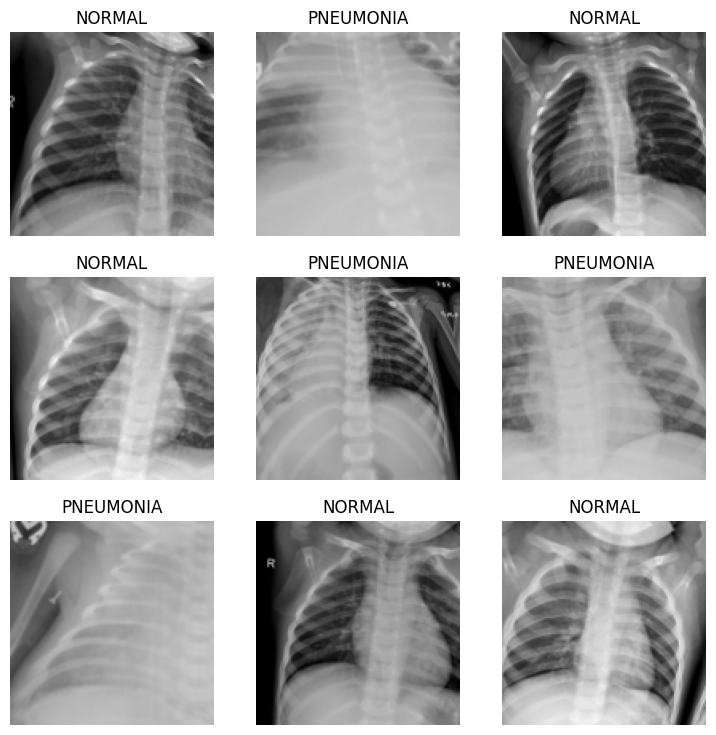

In [9]:
dls.show_batch()

## Entrenando el modelo

### Callbacks

In [10]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='modelResnet18')  
]

## Construyendo el modelo

In [11]:
learn = vision_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 206MB/s]


### Learning rate finder

SuggestedLRs(valley=0.0020892962347716093)

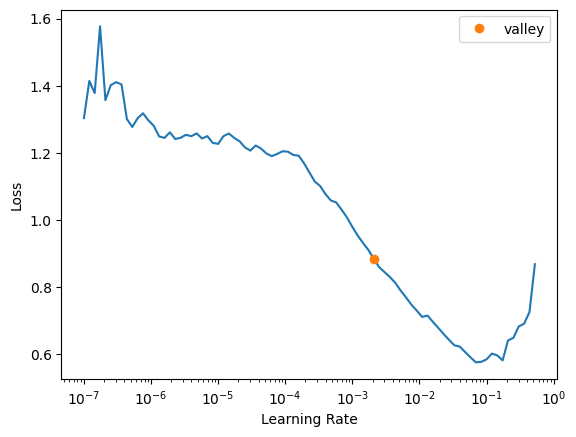

In [12]:
learn.lr_find()

### Fine-tuning

epoch,train_loss,valid_loss,accuracy,time
0,1.256889,1.936826,0.750000,00:00


Better model found at epoch 0 with valid_loss value: 1.9368258714675903.


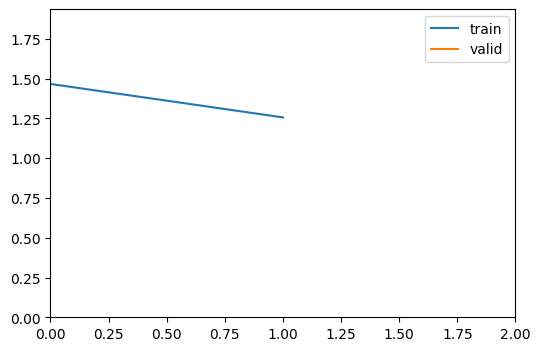

epoch,train_loss,valid_loss,accuracy,time
0,1.255854,1.417999,0.750000,00:01
1,1.286343,1.198647,0.750000,00:00
2,1.128441,1.210665,0.750000,00:00
3,1.099333,0.991049,0.750000,00:00
4,1.094206,0.868147,0.750000,00:00
5,1.003178,0.680040,0.750000,00:00
6,0.888106,0.626190,0.750000,00:01
7,0.810968,0.544020,0.750000,00:00
8,0.758512,0.454232,0.750000,00:00
9,0.710479,0.421711,0.750000,00:00


Better model found at epoch 0 with valid_loss value: 1.4179987907409668.


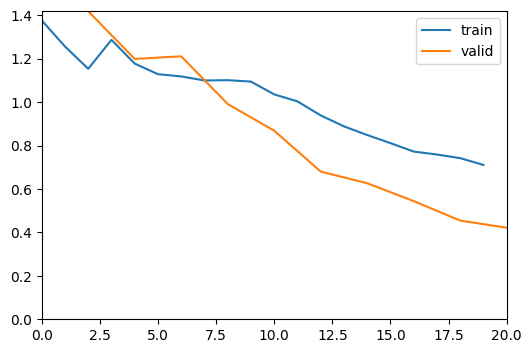

Better model found at epoch 1 with valid_loss value: 1.1986472606658936.
Better model found at epoch 3 with valid_loss value: 0.9910491704940796.
Better model found at epoch 4 with valid_loss value: 0.8681468367576599.
Better model found at epoch 5 with valid_loss value: 0.6800404191017151.
Better model found at epoch 6 with valid_loss value: 0.6261897087097168.
Better model found at epoch 7 with valid_loss value: 0.5440201163291931.
Better model found at epoch 8 with valid_loss value: 0.45423218607902527.
Better model found at epoch 9 with valid_loss value: 0.42171111702919006.


In [13]:
learn.fine_tune(10,base_lr=1e-3)

In [14]:
Path('models').ls()

(#1) [Path('models/modelResnet18.pth')]

In [15]:
learn.to_fp32()
learn.export()

In [16]:
Path().ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

## Evaluando el modelo

### Evaluando el modelo en el conjunto de test 

In [ ]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [ ]:
learn.dls = dlsTest

In [ ]:
learn.validate()

Una vez que has entrenado el modelo utilizalo para aplicar la técnica de pseudo-labeling. Para ello deberás utilizar el modelo para obtener la clase de cada una de las imágenes de la carpeta ``unlabelled`` y su nivel de confianza. Crea un nuevo dataset análogo al inicial pero donde aquellas imágenes cuya predicción tenga un nivel de confianza superior a 0.8 se almacenen en la carpeta correspondiente del conjunto de entrenamiento. 

Vuelve a entrenar el modelo con el nuevo conjunto de entrenamiento, y evalúalo en el conjunto de test. 